# 1) Imports

In [146]:
import pandas as pd
import numpy as np
import unidecode
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from geopy.distance import great_circle

# 2) Coleta dos dados

In [147]:
top_muns = pd.read_csv("../Dados/Tabela_final/municipios_potenciais.csv").drop(columns=['Unnamed: 0'])
mun_ser = pd.read_csv('../Dados/Views/municipios_sertao.csv').drop(columns = 'Unnamed: 0')
agro = pd.read_csv("../Dados/Tabela_final/dados_producao_agricola.csv").drop(columns=['Unnamed: 0'])
solos = pd.read_csv("../Dados/Views/solos_municipios.csv").drop(columns=['Unnamed: 0'])
solos = mun_ser.drop(columns=['LATITUDE', 'LONGITUDE']).merge(solos, on = 'IBGE7').drop(columns=['IBGE7', 'UF'])

# 3) Análise dos dados

## 3.1) Distribuição dos dados

### 3.1.1) Dados de agricultura

In [129]:
agro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9489 entries, 0 to 9521
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MUNICIPIO      9489 non-null   object 
 1   PRODUTO        9489 non-null   object 
 2   AREA_PLANTADA  9489 non-null   float64
 3   AREA_COLHIDA   9489 non-null   float64
 4   REND_MEDIO     9489 non-null   float64
 5   VALOR_PROD     9489 non-null   float64
dtypes: float64(4), object(2)
memory usage: 518.9+ KB


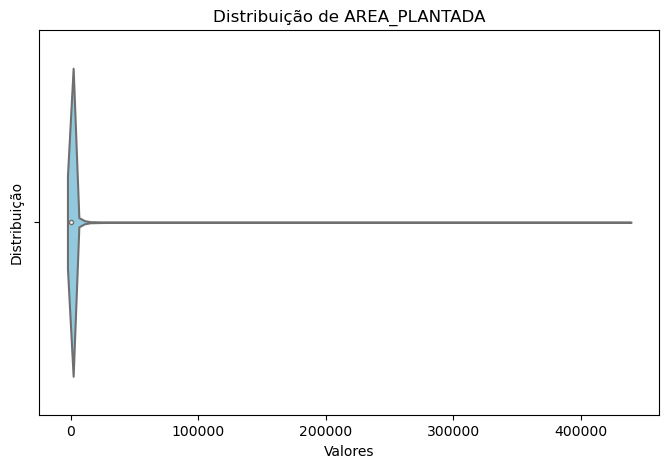

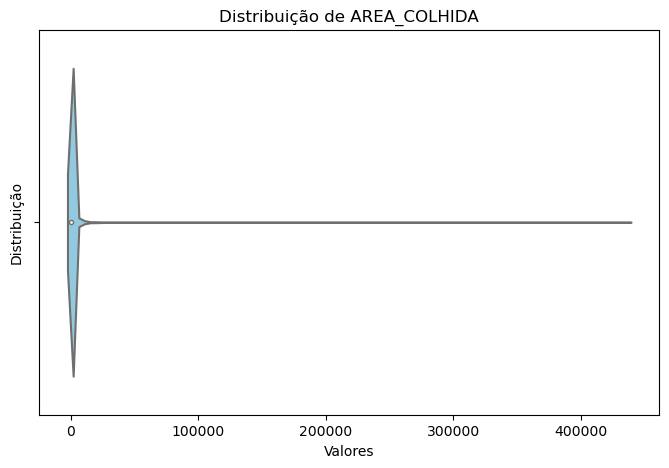

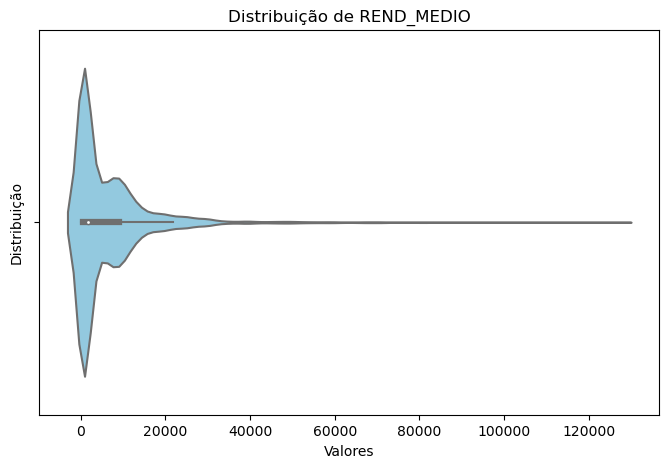

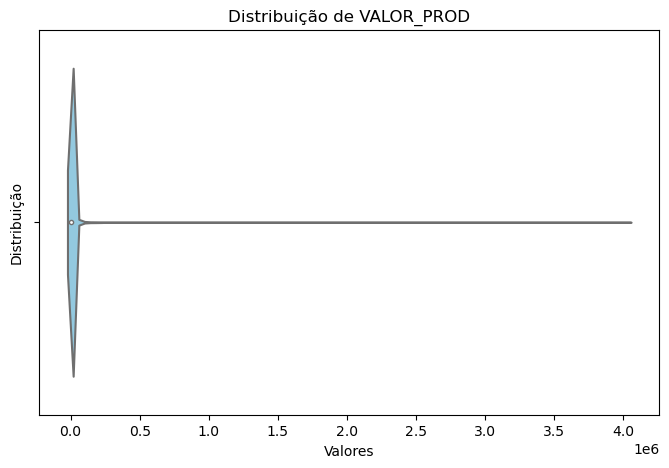

In [130]:
for column in ['AREA_PLANTADA', 'AREA_COLHIDA', 'REND_MEDIO','VALOR_PROD']:
    plt.figure(figsize=(8, 5)) 
    sns.violinplot(x=agro[column], color='skyblue')
    plt.xlabel('Valores')  
    plt.ylabel('Distribuição')  
    plt.title(f'Distribuição de {column}')  
    plt.show()

### 3.1.2) Dados de solos

In [131]:
solos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3401 entries, 0 to 3400
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   NOME        3401 non-null   object 
 1   SOLO        3401 non-null   object 
 2   AREA_TOTAL  3401 non-null   float64
dtypes: float64(1), object(2)
memory usage: 106.3+ KB


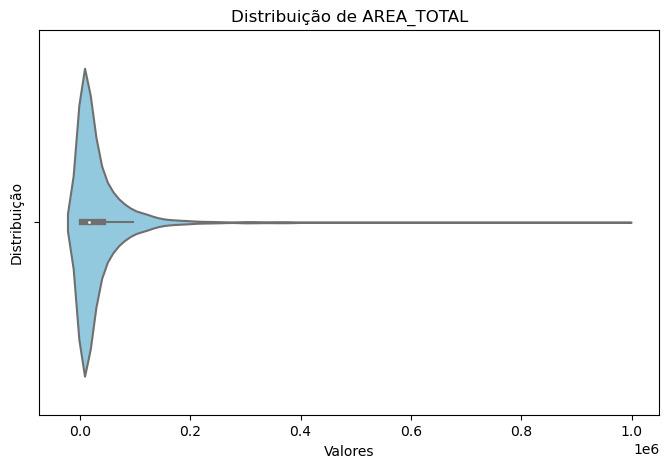

In [132]:
plt.figure(figsize=(8, 5))
sns.violinplot(x=solos['AREA_TOTAL'], color='skyblue')     
plt.xlabel('Valores')
plt.ylabel('Distribuição') 
plt.title(f'Distribuição de AREA_TOTAL') 
plt.show()

### 3.1) Identificando os municípios mais próximos do município prioritário

In [164]:
def muns_prox(raio):

    resultado = {}

    for _, row_top in top_muns.iterrows():
        municipio_interesse = row_top['NOME']  
        coordenadas_interesse = (row_top['LATITUDE'], row_top['LONGITUDE'])

        municipios_proximos = {}

        for _, row_ser in mun_ser.iterrows():
            coordenadas_ser = (row_ser['LATITUDE'], row_ser['LONGITUDE'])

            distancia = great_circle(coordenadas_interesse, coordenadas_ser).kilometers

            if distancia <= raio:
                municipios_proximos[row_ser['NOME']] = round(distancia,2)

        resultado[municipio_interesse] = municipios_proximos

    return resultado

In [166]:
resultado = muns_prox(50)

### 3.2) Identificando as atividades agrícolas mais exploradas em um raio de 50km do município de interesse

In [173]:
def atividades_agricolas(resultado, nome):
    muns_prox = list(resultado[nome].keys())
    atv_agr_prox = agro[agro['NOME'].isin(muns_prox)]
    atv_agr_prox = atv_agr_prox[['PRODUTO', 'AREA_PLANTADA', 'VALOR_PROD']].groupby('PRODUTO').sum().reset_index().sort_values(by='VALOR_PROD', ascending = False)
    atv_agr_prox['REND_AREA'] = atv_agr_prox['VALOR_PROD']/atv_agr_prox['AREA_PLANTADA']
    solos_prox = solos[solos['NOME'].isin(muns_prox)].drop(columns=['NOME'])
    solos_prox = solos_prox.groupby('SOLO').sum().reset_index().sort_values(by='AREA_TOTAL', ascending = False)
    print('Total')
    display(atv_agr_prox)
    display(solos_prox)
    
    for mun in resultado[nome]:
        atv_agr_prox = agro[agro['NOME']==mun]
        atv_agr_prox = atv_agr_prox[['PRODUTO', 'AREA_PLANTADA', 'VALOR_PROD']].groupby('PRODUTO').sum().reset_index().sort_values(by='VALOR_PROD', ascending = False)
        atv_agr_prox['REND_AREA'] = atv_agr_prox['VALOR_PROD']/atv_agr_prox['AREA_PLANTADA']
        
        solos_prox = solos[solos['NOME']==mun].drop(columns=['NOME'])
        solos_prox = solos_prox.groupby('SOLO').sum().reset_index().sort_values(by='AREA_TOTAL', ascending = False)
        
        if atv_agr_prox.shape[0] == 0:
            pass
        else:
            print(mun)
            display(atv_agr_prox)
            display(solos_prox)

In [175]:
atividades_agricolas(resultado, 'MONTE SANTO')

Total


,PRODUTO,AREA_PLANTADA,VALOR_PROD,REND_AREA
5,MILHO (EM GRAO),50333.333333,99447.333333,1.975775
3,FEIJAO (EM GRAO),48855.000000,74131.333333,1.517375
4,MANDIOCA,4111.666667,23146.000000,5.629347
2,CASTANHA DE CAJU,1062.333333,760.000000,0.715406
0,BANANA,21.333333,348.333333,16.328125
1,BATATA-DOCE,3.333333,41.666667,12.500000


,SOLO,AREA_TOTAL
6,SXe - Planossolos Haplicos Eutroficos,546281.678800
5,RRe - Neossolos Regoliticos Eutroficos,138945.991192
0,CXve - Cambissolos Haplicos Ta Eutroficos,63653.886201
2,PVAd - Argissolos Vermelho-Amarelos Distroficos,53856.149036
4,RQo - Neossolos Quartzarenicos Orticos,41773.600707
3,RLd - Neossolos Litolicos Distroficos,25751.551286
1,LAd - Latossolos Amarelos Distroficos,1034.400607


CANSANCAO


,PRODUTO,AREA_PLANTADA,VALOR_PROD,REND_AREA
2,FEIJAO (EM GRAO),8266.666667,3799.666667,0.459637
4,MILHO (EM GRAO),8000.000000,3216.333333,0.402042
3,MANDIOCA,520.000000,2633.333333,5.064103
0,BANANA,21.333333,348.333333,16.328125
1,CASTANHA DE CAJU,8.000000,4.000000,0.500000


,SOLO,AREA_TOTAL
1,SXe - Planossolos Haplicos Eutroficos,105184.092010
0,RRe - Neossolos Regoliticos Eutroficos,34794.219167


EUCLIDES DA CUNHA


,PRODUTO,AREA_PLANTADA,VALOR_PROD,REND_AREA
2,FEIJAO (EM GRAO),20066.666667,56344.000000,2.807841
4,MILHO (EM GRAO),14000.000000,52795.666667,3.771119
3,MANDIOCA,3000.000000,15999.333333,5.333111
1,CASTANHA DE CAJU,1000.000000,710.666667,0.710667
0,BATATA-DOCE,3.333333,41.666667,12.500000


,SOLO,AREA_TOTAL
4,SXe - Planossolos Haplicos Eutroficos,61680.034849
0,CXve - Cambissolos Haplicos Ta Eutroficos,56289.046048
1,PVAd - Argissolos Vermelho-Amarelos Distroficos,53856.149036
2,RLd - Neossolos Litolicos Distroficos,25751.551286
3,RQo - Neossolos Quartzarenicos Orticos,13114.196016


MONTE SANTO


,PRODUTO,AREA_PLANTADA,VALOR_PROD,REND_AREA
3,MILHO (EM GRAO),9000.000000,34171.666667,3.796852
1,FEIJAO (EM GRAO),9016.666667,8225.333333,0.912237
2,MANDIOCA,205.000000,1577.666667,7.695935
0,CASTANHA DE CAJU,5.000000,4.000000,0.800000


,SOLO,AREA_TOTAL
1,SXe - Planossolos Haplicos Eutroficos,235105.029260
0,RRe - Neossolos Regoliticos Eutroficos,98113.543571


NORDESTINA


,PRODUTO,AREA_PLANTADA,VALOR_PROD,REND_AREA
2,MILHO (EM GRAO),2166.666667,1571.333333,0.725231
1,MANDIOCA,96.666667,130.666667,1.351724
0,FEIJAO (EM GRAO),1833.333333,68.000000,0.037091


,SOLO,AREA_TOTAL
1,SXe - Planossolos Haplicos Eutroficos,40353.565744
0,RRe - Neossolos Regoliticos Eutroficos,6038.228454


QUIJINGUE


,PRODUTO,AREA_PLANTADA,VALOR_PROD,REND_AREA
3,MILHO (EM GRAO),17166.666667,7692.333333,0.448097
1,FEIJAO (EM GRAO),9671.666667,5694.333333,0.588764
2,MANDIOCA,290.000000,2805.000000,9.672414
0,CASTANHA DE CAJU,49.333333,41.333333,0.837838


,SOLO,AREA_TOTAL
3,SXe - Planossolos Haplicos Eutroficos,103958.956936
2,RQo - Neossolos Quartzarenicos Orticos,28659.404691
0,CXve - Cambissolos Haplicos Ta Eutroficos,7364.840152
1,LAd - Latossolos Amarelos Distroficos,1034.400607


In [80]:
top_muns[['NOME', '']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 60 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   IBGE7                15 non-null     int64  
 1   UF                   15 non-null     object 
 2   NOME                 15 non-null     object 
 3   LATITUDE             15 non-null     float64
 4   LONGITUDE            15 non-null     float64
 5   DIST_EF_PUB          15 non-null     float64
 6   DIST_EM_PUB          15 non-null     float64
 7   IDEB_AI              15 non-null     float64
 8   IDEB_AF              15 non-null     float64
 9   DOCSUP_EF_PUB        15 non-null     float64
 10  DOCSUP_EM_PUB        15 non-null     float64
 11  TXNASC7C             15 non-null     float64
 12  TXNBAIXOP            15 non-null     float64
 13  PINTERSAP            15 non-null     float64
 14  PINTERDRSAI          15 non-null     float64
 15  REN_PIBPC_D          15 non-null     float